<h2>Part 3: Using classification to predict weather</h2>

The meteorological dataset D3.csv consists of 142,219 instances of weather encounters represented by 23 variables pertaining to weather information from 49 locations in Australia. The data was collected by BOM over a period of 10 years. This is the data you used in Assignment 1: Problem-solving task and have processed to deal with common errors such as missing values, etc. We now provide a reasonably clean copy of this data for building the models.

Use this processed data to perform predictive modelling with different methods to classify if it will rain tomorrow (reported as 1) or not (reported as 0).

<h3>Classification technique: Decision Tree</h3>

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import pydot
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# Will use the BOM data that was already pre-processed from assignment 1
BOM_data = pd.read_csv('BOM_processed.csv')

In [3]:
# Next we must drop the variables that won't be used
# We will use variables:
# RainTomorrow, Temp9am, Pressure9am, Humidity9am, Cloud9am, Month, Location
# Drop the rest
BOM_data = BOM_data.drop(['Unnamed: 0','Date','Day','MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustDir','WindGustSpeed',
                          'WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm','Humidity3pm','Pressure3pm','Cloud3pm',
                          'Temp3pm','RainLastWeek','RainToday','ENSO','Year','Location'], axis=1)

In [4]:
# Will need to remove all NaN from the target variable (RainTomorrow) and input variables
# BOM_data = BOM_data.dropna(subset=['RainTomorrow'])
BOM_data = BOM_data.dropna()

In [5]:
# Convert categorical data (Location) to binary. 
# all numerical variables are automatically excluded
BOM_data=pd.get_dummies(BOM_data)

In [6]:
# Split out the target and input variables. Target variable is RainTomorrow
y = BOM_data['RainTomorrow'] # Target variable
X = BOM_data.drop(['RainTomorrow'], axis=1) # All other variables are input variables

In [7]:
# Now will normalise the data as the input variables all use different scales
# Chose min-max normalisation because outliers have already been removed, otherwsie would have used z-scaler
# x_vals = X.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x_vals)
# X2 = pd.DataFrame(x_scaled)
# print(X2)

In [8]:
# Transform to a matrix ready for sklearn
X_mat = X.to_numpy()

In [9]:
# Now partition the data into training and test sets
# Will use k-fold cross-validation
# setting random state
rs = 10

# Split into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

In [10]:
# Standardise data ready for logistic regression
# initialise a standard scaler object
scaler = StandardScaler()

# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# use the statistic that you learned from training to transform test data
# NEVER learn from test data, this is supposed to be a set of dataset
# that the model has never seen before
X_test = scaler.transform(X_test)

Before scaling
-------------
Variable #0: min 1.0, max 12.0, mean 6.40 and std dev 3.43
Variable #1: min 0.0, max 100.0, mean 68.70 and std dev 18.74
Variable #2: min 980.5, max 1041.0, mean 1017.71 and std dev 7.11
Variable #3: min 0.0, max 9.0, mean 4.46 and std dev 2.36
Variable #4: min -1.7, max 40.2, mean 17.11 and std dev 6.32
After scaling
-------------
Variable #0: min -1.5741372200138217, max 1.6348890295005785, mean 0.00 and std dev 1.00
Variable #1: min -3.6666398351853333, max 1.6702555397746905, mean 0.00 and std dev 1.00
Variable #2: min -5.231299803644421, max 3.2751886514593824, mean 0.00 and std dev 1.00
Variable #3: min -1.8893988791881309, max 1.9251914196818953, mean -0.00 and std dev 1.00
Variable #4: min -2.9740167757390603, max 3.6514829473981134, mean 0.00 and std dev 1.00


In [11]:
# Build decision tree using the training dataset

rs = 10
# simple decision tree training
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

In [12]:
# Check how did it perform
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 0.9999184624344788
Test accuracy: 0.7282091702225967


In [13]:
# Performed well on the training dataset, but not as well (but still ok) on the test dataset
# Probably overfitting occurring.
# Changed max depth to 10 anf this improved to 80% on both

In [14]:
# Find important features
# grab feature importances from the model and feature name from the original X
importances = model.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', importances[i])

Pressure9am : 0.3144726816347362
Temp9am : 0.28759839575272866
Humidity9am : 0.2230882065462259
Month : 0.09232886830214537
Cloud9am : 0.08251184776416377


In [15]:
# Look at characteristics of the tree
print("Number of nodes: ",model.tree_.node_count)
print("Maximum depth: ",model.tree_.max_depth)

Number of nodes:  37293
Maximum depth:  38


In [16]:
# Visualise the tree
dotfile = StringIO()
export_graphviz(model, out_file=dotfile, feature_names=X.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph[0].write_png("RainTomorrow_default_tree.png")

TypeError: 'Dot' object is not subscriptable

In [18]:
# Try to find the optimal parameters using GridSearchCV

# For each of the 3 parameters, specify the range to try
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(1, 16),
          'min_samples_leaf': range(0, 25, 5)[1:]} # Use the range of 1-25 with step of 5.




In [19]:
cv_1 = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs),return_train_score=True, cv=10)


In [20]:
cv_1.fit(X_train, y_train)

C:\Users\melan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\melan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\melan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\melan\anaconda3\Lib\site-packages\sklearn\base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "C:\Users\melan\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 426, in predict
    X = self._validate_X_predict(X, check_inp

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 16),
                         'min_samples_leaf': range(5, 25, 5)},
             return_train_score=True)

In [21]:
# Now return all the combination of hyperparameters and their respective score
result_set = cv_1.cv_results_
result_set


{'mean_fit_time': array([0.10837042, 0.10725684, 0.11767747, 0.12063339, 0.21239965,
        0.17861576, 0.17653372, 0.19445539, 0.29054267, 0.32705555,
        0.36367097, 0.2683702 , 0.31084085, 0.43823037, 0.35331981,
        0.31633389, 0.4187099 , 0.45504971, 0.37832422, 0.40873637,
        0.54873085, 0.44334922, 0.44389691, 0.52521   , 0.49801197,
        0.48364284, 0.54110525, 0.46830113, 0.53157969, 0.60075049,
        0.51591523, 0.59632292, 0.68106277, 0.53692751, 0.58149991,
        0.51925259, 0.66776762, 0.61981895, 0.73347852, 0.68837137,
        0.87660346, 0.96964273, 0.86857901, 0.86940553, 0.89792764,
        0.89785991, 0.89448624, 0.95639369, 0.938116  , 0.75924881,
        0.77968481, 0.69328532, 0.84660878, 1.1435159 , 0.93265512,
        0.92513306, 0.95074937, 0.9091027 , 0.86802289, 0.75216477,
        0.10048478, 0.12725928, 0.11781678, 0.11524503, 0.21366217,
        0.2064959 , 0.21617866, 0.19002531, 0.3510633 , 0.34983807,
        0.32544668, 0.26210127,

Total number of models:  120


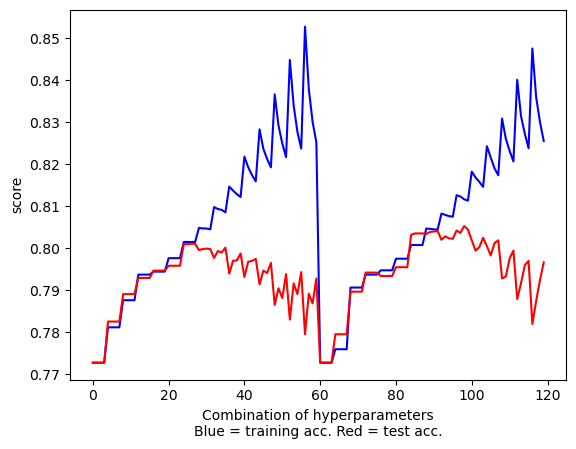

In [22]:
# Plot the train score and test score for the first split of the data (there are 10)

train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Combination of hyperparameters\nBlue = training acc. Red = test acc.')
plt.ylabel('score')
plt.show()

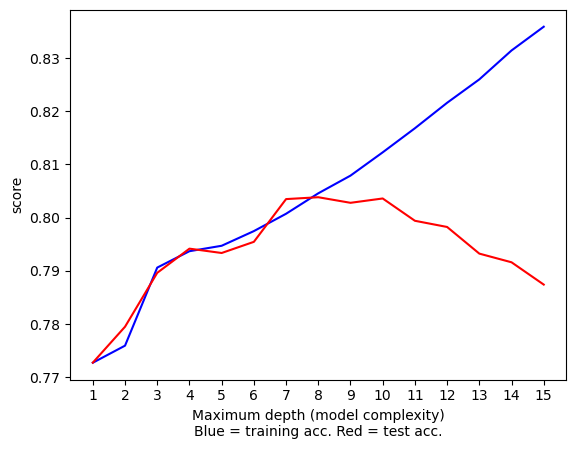

In [23]:
# There are a total of 120 combinations of hyperparameters (2 x 15 x 5) meaning that there are 120 models. 
# Let us now focus only on the max_depth to understand the bias and variance for the 
# fixed criterion = 'entropy' and max_sample_leaf = 10.

result_set['params']
dd = pd.DataFrame(result_set['params'])

index_ = list(dd.index[(dd['criterion']=='entropy') & (dd['min_samples_leaf']==10)])
max_depth_train = []
max_depth_test = []
for i in range(0,len(index_)):
    max_depth_train.append(train_result[index_[i]])
    max_depth_test.append(test_result[index_[i]])
plt.plot(range(1, len(max_depth_train)+1), max_depth_train, 'b', range(1,len(max_depth_test)+1), max_depth_test, 'r')
plt.xlabel('Maximum depth (model complexity)\nBlue = training acc. Red = test acc.')
plt.ylabel('score')
plt.xticks(np.arange(1, len(max_depth_train)+1, 1))
plt.show()

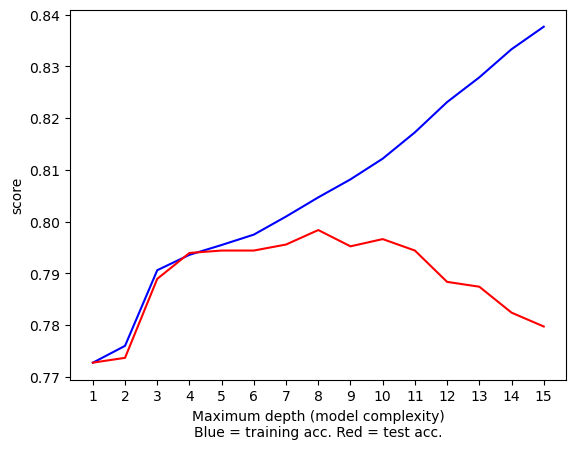

In [24]:
# Now repeat for for split 1
train_result = result_set['split1_train_score']
test_result = result_set['split1_test_score']
max_depth_train = []
max_depth_test = []
for i in range(0,len(index_)):
    max_depth_train.append(train_result[index_[i]])
    max_depth_test.append(test_result[index_[i]])
plt.plot(range(1, len(max_depth_train)+1), max_depth_train, 'b', range(1,len(max_depth_test)+1), max_depth_test, 'r')
plt.xlabel('Maximum depth (model complexity)\nBlue = training acc. Red = test acc.')
plt.ylabel('score')
plt.xticks(np.arange(1, len(max_depth_train)+1, 1))
plt.show()

In [25]:
# Show the best parameters:
print(cv_1.best_params_)

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 15}


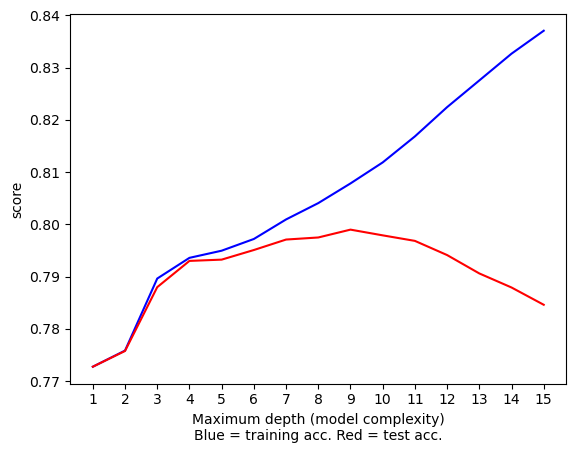

In [26]:
# Show the mean values for all of the splits vs the max depth value
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']

max_depth_train = []
max_depth_test = []
index_
for i in range(len(index_)):
    max_depth_train.append(train_result[index_[i]])
    max_depth_test.append(test_result[index_[i]])
plt.plot(range(1, len(max_depth_train)+1), max_depth_train, 'b', range(1,len(max_depth_test)+1), max_depth_test, 'r')
plt.xlabel('Maximum depth (model complexity)\nBlue = training acc. Red = test acc.')
plt.xticks(np.arange(1, len(max_depth_train)+1, 1))
plt.ylabel('score')
plt.show()

In [27]:
# Now repeat the tree with the optimal parameters
# Build decision tree using the training dataset

rs = 10
# simple decision tree training
model_optimised = DecisionTreeClassifier(random_state=rs, criterion='entropy', max_depth=9, min_samples_leaf=15)
model_optimised.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=15,
                       random_state=10)

In [28]:
print("Train accuracy:", model_optimised.score(X_train, y_train))
print("Test accuracy:", model_optimised.score(X_test, y_test))
print("Number of nodes: ",model_optimised.tree_.node_count)
print("Maximum depth: ",model_optimised.tree_.max_depth)

Train accuracy: 0.8079440885264997
Test accuracy: 0.7999347702008535
Number of nodes:  829
Maximum depth:  9


In [29]:
# Find important features
# grab feature importances from the model and feature name from the original X
importances = model_optimised.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', importances[i])

Humidity9am : 0.3474654927053538
Pressure9am : 0.3379490298144074
Cloud9am : 0.1389799493532587
Temp9am : 0.09370361636483789
Month : 0.08190191176214223


In [30]:
# Visualise the tree
dotfile = StringIO()
export_graphviz(model_optimised, out_file=dotfile, feature_names=X.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("RainTomorrow_optimised_tree.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.511241 to fit



True

In [31]:
# Now compare the default and optimised trees using the AUC - Area under ROC curve
# Where ROC = Receiver Operating Characteristic.
# AUC ROC refers to the ability of binary classifier to classify with varied discrimination threshold using a graphical plot.
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_optimised = model_optimised.predict_proba(X_test)

roc_index = roc_auc_score(y_test, y_pred_proba[:, 1])
roc_index_optimised = roc_auc_score(y_test, y_pred_proba_optimised[:, 1])

print("ROC index on test for default tree:", roc_index)
print("ROC index on test for optimised tree:", roc_index_optimised)

ROC index on test for default tree: 0.6246413529817878
ROC index on test for optimised tree: 0.7803333172064736


In [32]:
# ROC is higher for the optimised tree, suggesting it is a better model

In [33]:
# Next plot the ROC curves for these models
# Need to calculate the false positive rate, true positive rate and thresholds used for each model.

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
fpr_optimised, tpr_optimised, thresholds_optimised = roc_curve(y_test, y_pred_proba_optimised[:,1])

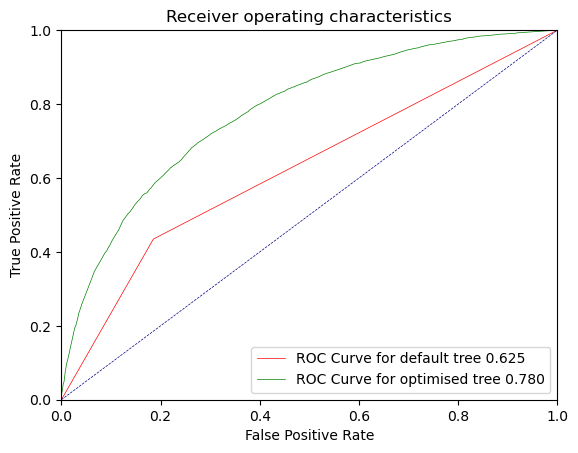

In [34]:
plt.plot(fpr, tpr, label='ROC Curve for default tree {:.3f}'.format(roc_index), color='red', lw=0.5)
plt.plot(fpr_optimised, tpr_optimised, label='ROC Curve for optimised tree {:.3f}'.format(roc_index_optimised), color='green', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

In [35]:
# Save the ROC outputs (`roc_index_dt_cv`,`fpr_dt_cv`, `tpr_dt_cv`) of the best performing model (optimised)
# so that we can use it in next two weeks for the comparision with other predictive mining models (Regression and Neural Network).
import pickle
dt_best = model_optimised
with open('DT.pickle', 'wb') as f:
    pickle.dump([dt_best,roc_index_optimised, fpr_optimised, tpr_optimised], f)

In [36]:
# Store variables so ROC curve can be performed on all predictive modelling trees in a different notebook
fpr_dt = fpr_optimised
tpr_dt = tpr_optimised
thresholds_dt = thresholds_optimised
roc_index_dt = roc_index_optimised

%store fpr_dt
%store tpr_dt
%store thresholds_dt
%store roc_index_dt

Stored 'fpr_dt' (ndarray)
Stored 'tpr_dt' (ndarray)
Stored 'thresholds_dt' (ndarray)
Stored 'roc_index_dt' (float64)
